In [1]:
import numpy as np
import random
import xgboost as xgb
import pandas as pd
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
import math
import pickle
import pdpbox
from pdpbox import pdp, get_dataset, info_plots
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [2]:
# 난수 시드 설정
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
# 데이터 로드
Data = pd.read_csv('C:/Users/hangang/Desktop/sci/02. LC-OCD for algal bloom/1_raw data/02_data_tradition.csv', encoding='utf-8')
X = Data.drop('Chl-a', axis=1)
y = Data['Chl-a']

In [4]:
# 정규화 방법 리스트
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
scaler_names = ['StandardScaler', 'MinMaxScaler', 'RobustScaler']

In [112]:
space = {
    'scaler': hp.choice('scaler', scalers),
    'n_estimators': hp.quniform('n_estimators', 10, 80, 1),
    'max_depth': hp.quniform('max_depth', 1, 5, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'min_samples_split': hp.quniform('min_samples_split', 1, 5, 1),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1),
    'subsample': hp.uniform('subsample', 0.1, 0.5),
    'max_features': hp.uniform('max_features', 0.1, 0.5)
}

In [113]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)

In [114]:
# 성능 지표 계산 함수
def calculate_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    return r2, rmse, mae, mse, mape, rmsle

In [115]:
# 하이퍼파라미터 튜닝을 위한 목적 함수 정의
def objective(params):
    scaler = params['scaler']
    n_estimators = int(params['n_estimators'])
    max_depth = int(params['max_depth'])
    learning_rate = params['learning_rate']
    min_samples_split = int(params['min_samples_split'])
    min_samples_leaf = int(params['min_samples_leaf'])
    subsample = params['subsample']
    max_features = params['max_features']
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        max_features=max_features,
        random_state=random_seed
    )
    
    # 교차 검증을 사용하여 모델 평가
    kf = KFold(n_splits=3, shuffle=True, random_state=random_seed)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')
    
    # 교차 검증에서 평균 MSE를 반환합니다.
    mean_mse = -1 * np.mean(cv_scores)
    
    return {'loss': mean_mse, 'status': STATUS_OK}

In [116]:
# 최적의 하이퍼파라미터 찾기
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=400, trials=trials, rstate=np.random.default_rng(random_seed))
best_params = space_eval(space, best)
best_scaler = best_params['scaler']
best_n_estimators = int(best_params['n_estimators'])
best_max_depth = int(best_params['max_depth'])
best_learning_rate = best_params['learning_rate']
best_min_samples_split = int(best_params['min_samples_split'])
best_min_samples_leaf = int(best_params['min_samples_leaf'])
best_subsample = best_params['subsample']
best_max_features = best_params['max_features']


100%|██████████████████████████████████████████████| 400/400 [00:20<00:00, 19.16trial/s, best loss: 28.908904235764975]


In [117]:
# 최적 모델 학습
X_train_scaled = best_scaler.fit_transform(X_train)
X_test_scaled = best_scaler.transform(X_test)

best_model = GradientBoostingRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    learning_rate=best_learning_rate,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    subsample=best_subsample,
    max_features=best_max_features,
    random_state=random_seed
)
best_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.11432012906851141,
                          max_features=0.350746344656149, min_samples_leaf=5,
                          min_samples_split=5, n_estimators=31, random_state=42,
                          subsample=0.406986815806588)

In [118]:
# 최종 테스트 세트 성능 측정
y_pred_train = best_model.predict(X_train_scaled)
y_pred_test = best_model.predict(X_test_scaled)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

In [119]:
# 성능 지표 출력
print(f"\nBest scaler: {best_scaler} with Test R2 score: {r2_test:.4f}")
print("Best hyperparameters:")
print(f"n_estimators: {best_n_estimators}, max_depth: {best_max_depth}, learning_rate: {best_learning_rate}, min_samples_split: {best_min_samples_split}, min_samples_leaf: {best_min_samples_leaf}, subsample: {best_subsample}, max_features: {best_max_features}")


Best scaler: MinMaxScaler() with Test R2 score: 0.5524
Best hyperparameters:
n_estimators: 31, max_depth: 3, learning_rate: 0.11432012906851141, min_samples_split: 5, min_samples_leaf: 5, subsample: 0.406986815806588, max_features: 0.350746344656149


In [120]:
# 최종 모델의 성능 평가
r2_train, rmse_train, mae_train, mse_train, mape_train, rmsle_train = calculate_metrics(y_train, y_pred_train)
print('Best Model Train Metrics:')
print(f'R2: {r2_train:.4f}, RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}, MSE: {mse_train:.4f}, MAPE: {mape_train:.4f}, RMSLE: {rmsle_train:.4f}')


Best Model Train Metrics:
R2: 0.7841, RMSE: 3.8048, MAE: 2.4139, MSE: 14.4762, MAPE: 0.3420, RMSLE: 0.3103


In [121]:
# 테스트 세트 성능 지표
r2_test, rmse_test, mae_test, mse_test, mape_test, rmsle_test = calculate_metrics(y_test, y_pred_test)
print('Best Model Test Metrics:')
print(f'R2: {r2_test:.4f}, RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}, MSE: {mse_test:.4f}, MAPE: {mape_test:.4f}, RMSLE: {rmsle_test:.4f}')


Best Model Test Metrics:
R2: 0.5524, RMSE: 5.6624, MAE: 3.6752, MSE: 32.0624, MAPE: 0.4356, RMSLE: 0.3963


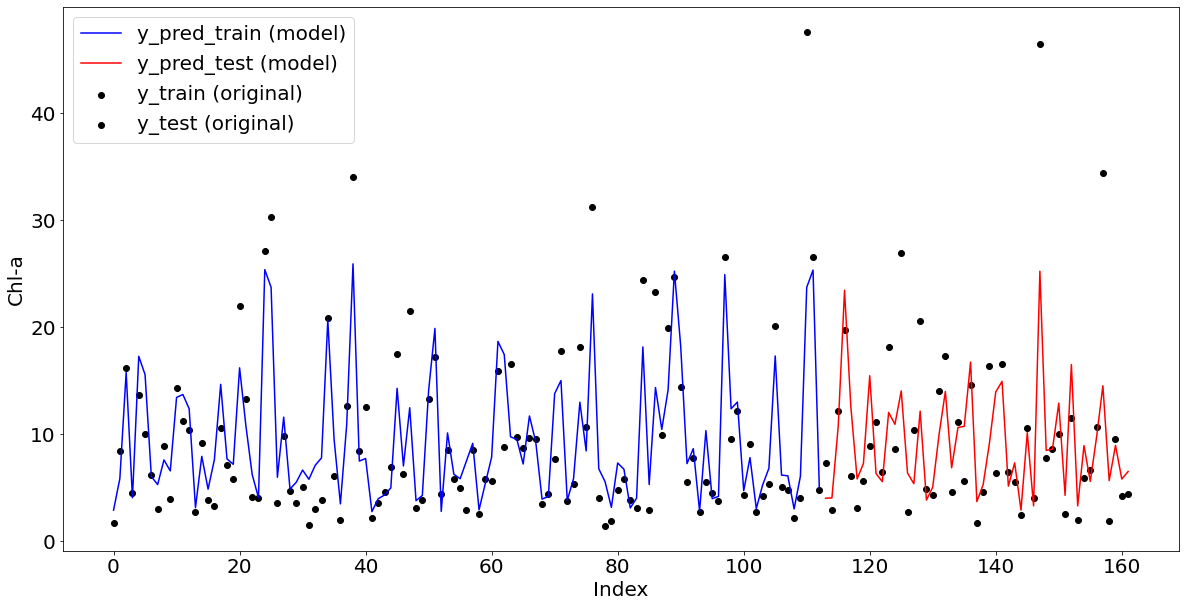

In [122]:
# 예측값을 시각화
plt.figure(figsize=(20, 10))

# 실제값(y)는 검은색 점으로 나타냅니다.
plt.scatter(range(len(y_train)), y_train, color='black', label='y_train (original)', marker='o')
plt.scatter(range(len(y_train), len(y_train) + len(y_test)), y_test, color='black', label='y_test (original)', marker='o')

# 예측값은 파란색 실선으로 나타냅니다.
plt.plot(range(len(y_train)), y_pred_train, color='blue', label='y_pred_train (model)')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_pred_test, color='red', label='y_pred_test (model)')

plt.xlabel('Index', fontsize=20)
plt.ylabel('Chl-a', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20)
plt.show()

In [123]:
# 예측값을 원래 데이터 순서에 맞게 정렬
y_pred = np.empty_like(y)
y_pred[:] = np.nan
y_pred[y_train.index] = y_pred_train
y_pred[y_test.index] = y_pred_test

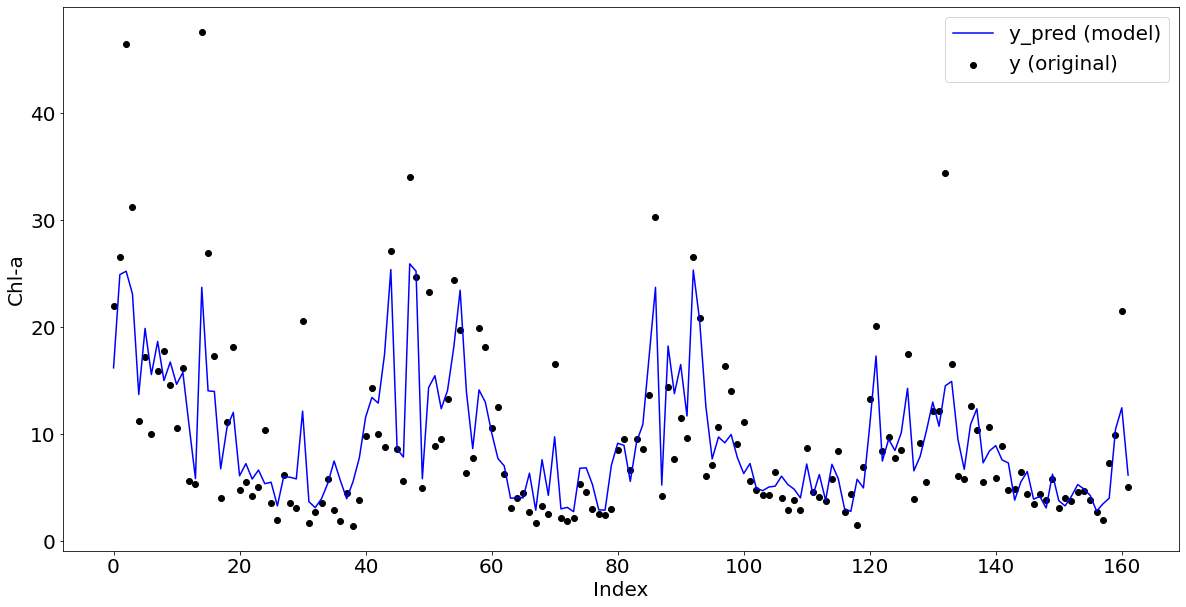

In [124]:
# 시각화
plt.figure(figsize=(20, 10))

# 실제값(y)는 검은색 점으로 나타냅니다.
plt.scatter(Data.index, y, color='black', label='y (original)', marker='o')

# 예측값은 파란색 실선으로 나타냅니다.
plt.plot(Data.index, y_pred, color='blue', label='y_pred (model)')

plt.xlabel('Index', fontsize=20)
plt.ylabel('Chl-a', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=20)
plt.show()

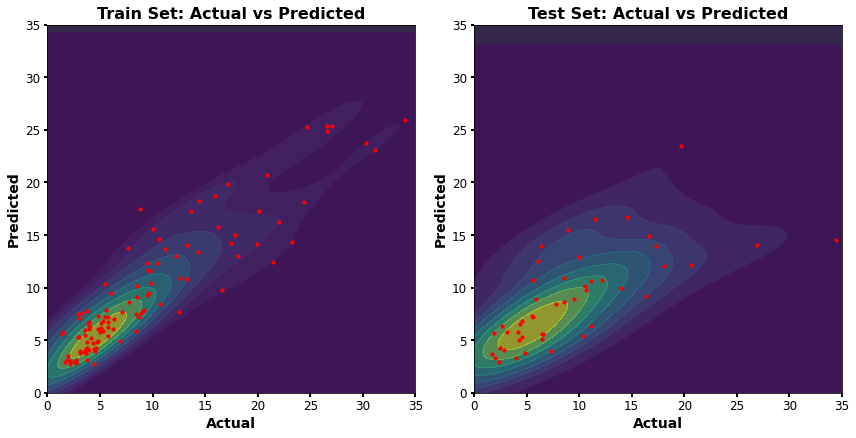

In [125]:
# 공통 축 범위 설정
min_value = 0
max_value = 35

# 플롯 크기 설정
plt.figure(figsize=(12, 6))

# 첫 번째 서브플롯: 훈련 세트
ax1 = plt.subplot(1, 2, 1)
sns.kdeplot(x=y_train, y=y_pred_train, cmap="viridis", shade=True, thresh=0, alpha=0.6, ax=ax1)
ax1.scatter(y_train, y_pred_train, color='red', s=10)
ax1.set_title('Train Set: Actual vs Predicted', fontsize=16, fontweight='bold')
ax1.set_xlabel('Actual', fontsize=14, fontweight='bold')
ax1.set_ylabel('Predicted', fontsize=14, fontweight='bold')
ax1.tick_params(axis='both', labelsize=12, labelrotation=0, width=2)
ax1.set_xlim(min_value, max_value)
ax1.set_ylim(min_value, max_value)
ax1.set_aspect('equal', adjustable='box')
ax1.set_facecolor('#35274a')  # 연보라색 배경

# 두 번째 서브플롯: 테스트 세트
ax2 = plt.subplot(1, 2, 2)
sns.kdeplot(x=y_test, y=y_pred_test, cmap="viridis", shade=True, thresh=0, alpha=0.6, ax=ax2)
ax2.scatter(y_test, y_pred_test, color='red', s=10)
ax2.set_title('Test Set: Actual vs Predicted', fontsize=16, fontweight='bold')
ax2.set_xlabel('Actual', fontsize=14, fontweight='bold')
ax2.set_ylabel('Predicted', fontsize=14, fontweight='bold')
ax2.tick_params(axis='both', labelsize=12, labelrotation=0, width=2)
ax2.set_xlim(min_value, max_value)
ax2.set_ylim(min_value, max_value)
ax2.set_aspect('equal', adjustable='box')
ax2.set_facecolor('#35274a')  # 연보라색 배경

# 레이아웃 조정 및 그림 저장
plt.tight_layout()
plt.savefig('C:/Users/hangang/Desktop/sci/02. LC-OCD for algal bloom/4_그림 모음/actual_vs_predicted_tradition_GBM.png', dpi=300)

# 플롯 보여주기
plt.show()

In [126]:
import pickle

# 모델을 저장했던 경로를 지정합니다.
model_save_path = "C:/Users/hangang/Desktop/sci/02. LC-OCD for algal bloom/3_모델 개발 중/best_GBM_model_tra.pkl"

# Save the best XGB model to Google Drive
with open(model_save_path, 'wb') as f:
    pickle.dump(best_model, f)